# Satellite-based model for rice crop mapping and monitoring 


## Load in dependencies

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('b6d222b511c74821b7271a745a656ea7')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [2]:
pip install xgboost

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

  Using cached tensorflow-2.16.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached tensorflow_io_gcs_filesystem-0.37.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached namex-0.0.8-py3-

## Dataset description

Before building the model, we need to load in the rice crop presence data. We have curated data from the Mekong Delta region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [4]:
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv")
crop_presence_data.head()

Latitude and Longitude Class of Land
0   (10.323727047081501, 105.2516346045924)          Rice
1  (10.322364360592521, 105.27843410554115)          Rice
2  (10.321455902933202, 105.25254306225168)          Rice
3  (10.324181275911162, 105.25118037576274)          Rice
4  (10.324635504740822, 105.27389181724476)          Rice

## Predictor variables

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. 
    
<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

### View RGB (real color) images from the time series

Data is available for Landsat-8 from April-2013 to now. Data is available for Landsat-9 from Feb-2022 to now. So, for the selected time window and missions there are typically views of our region every 8 days. But, due to scene overlaps, there are few more scenes within those 8-day increments. For this example over 5 months, there are 31 time slices that touch our region. Unfortunately, there are only 7 very clear scenes and several other partially cloudy scenes.

In [5]:
# Sample Rice Crop Field in An Giang, Vietnam
lat_long = (10.4391, 105.3338) # Lat-Lon centroid location
box_size_deg = 0.10 # Surrounding box in degrees

# Calculate the Lat-Lon bounding box region
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2
bounds = (min_lon, min_lat, max_lon, max_lat)

# Define the time window
time_window="2021-12-01/2022-04-30"

In [6]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    collections=["landsat-c2-l2"], 
    bbox=bounds, 
    datetime=time_window,
    query={"platform": {"in": ["landsat-8", "landsat-9"]},},
)
items = list(search.get_all_items())
print('This is the number of scenes in our region:',len(items))

This is the number of scenes in our region: 31


In [7]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
)

# Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
# https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
xx['red'] = (xx['red']*0.0000275)-0.2
xx['green'] = (xx['green']*0.0000275)-0.2
xx['blue'] = (xx['blue']*0.0000275)-0.2
xx['nir08'] = (xx['nir08']*0.0000275)-0.2

# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset> Size: 146MB
Dimensions:      (latitude: 372, longitude: 372, time: 31)
Coordinates:
  * latitude     (latitude) float64 3kB 10.49 10.49 10.49 ... 10.39 10.39 10.39
  * longitude    (longitude) float64 3kB 105.3 105.3 105.3 ... 105.4 105.4 105.4
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 248B 2021-12-01T03:20:47.203656 ... 20...
Data variables:
    red          (time, latitude, longitude) float64 34MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>
    green        (time, latitude, longitude) float64 34MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 34MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 34MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 9MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>

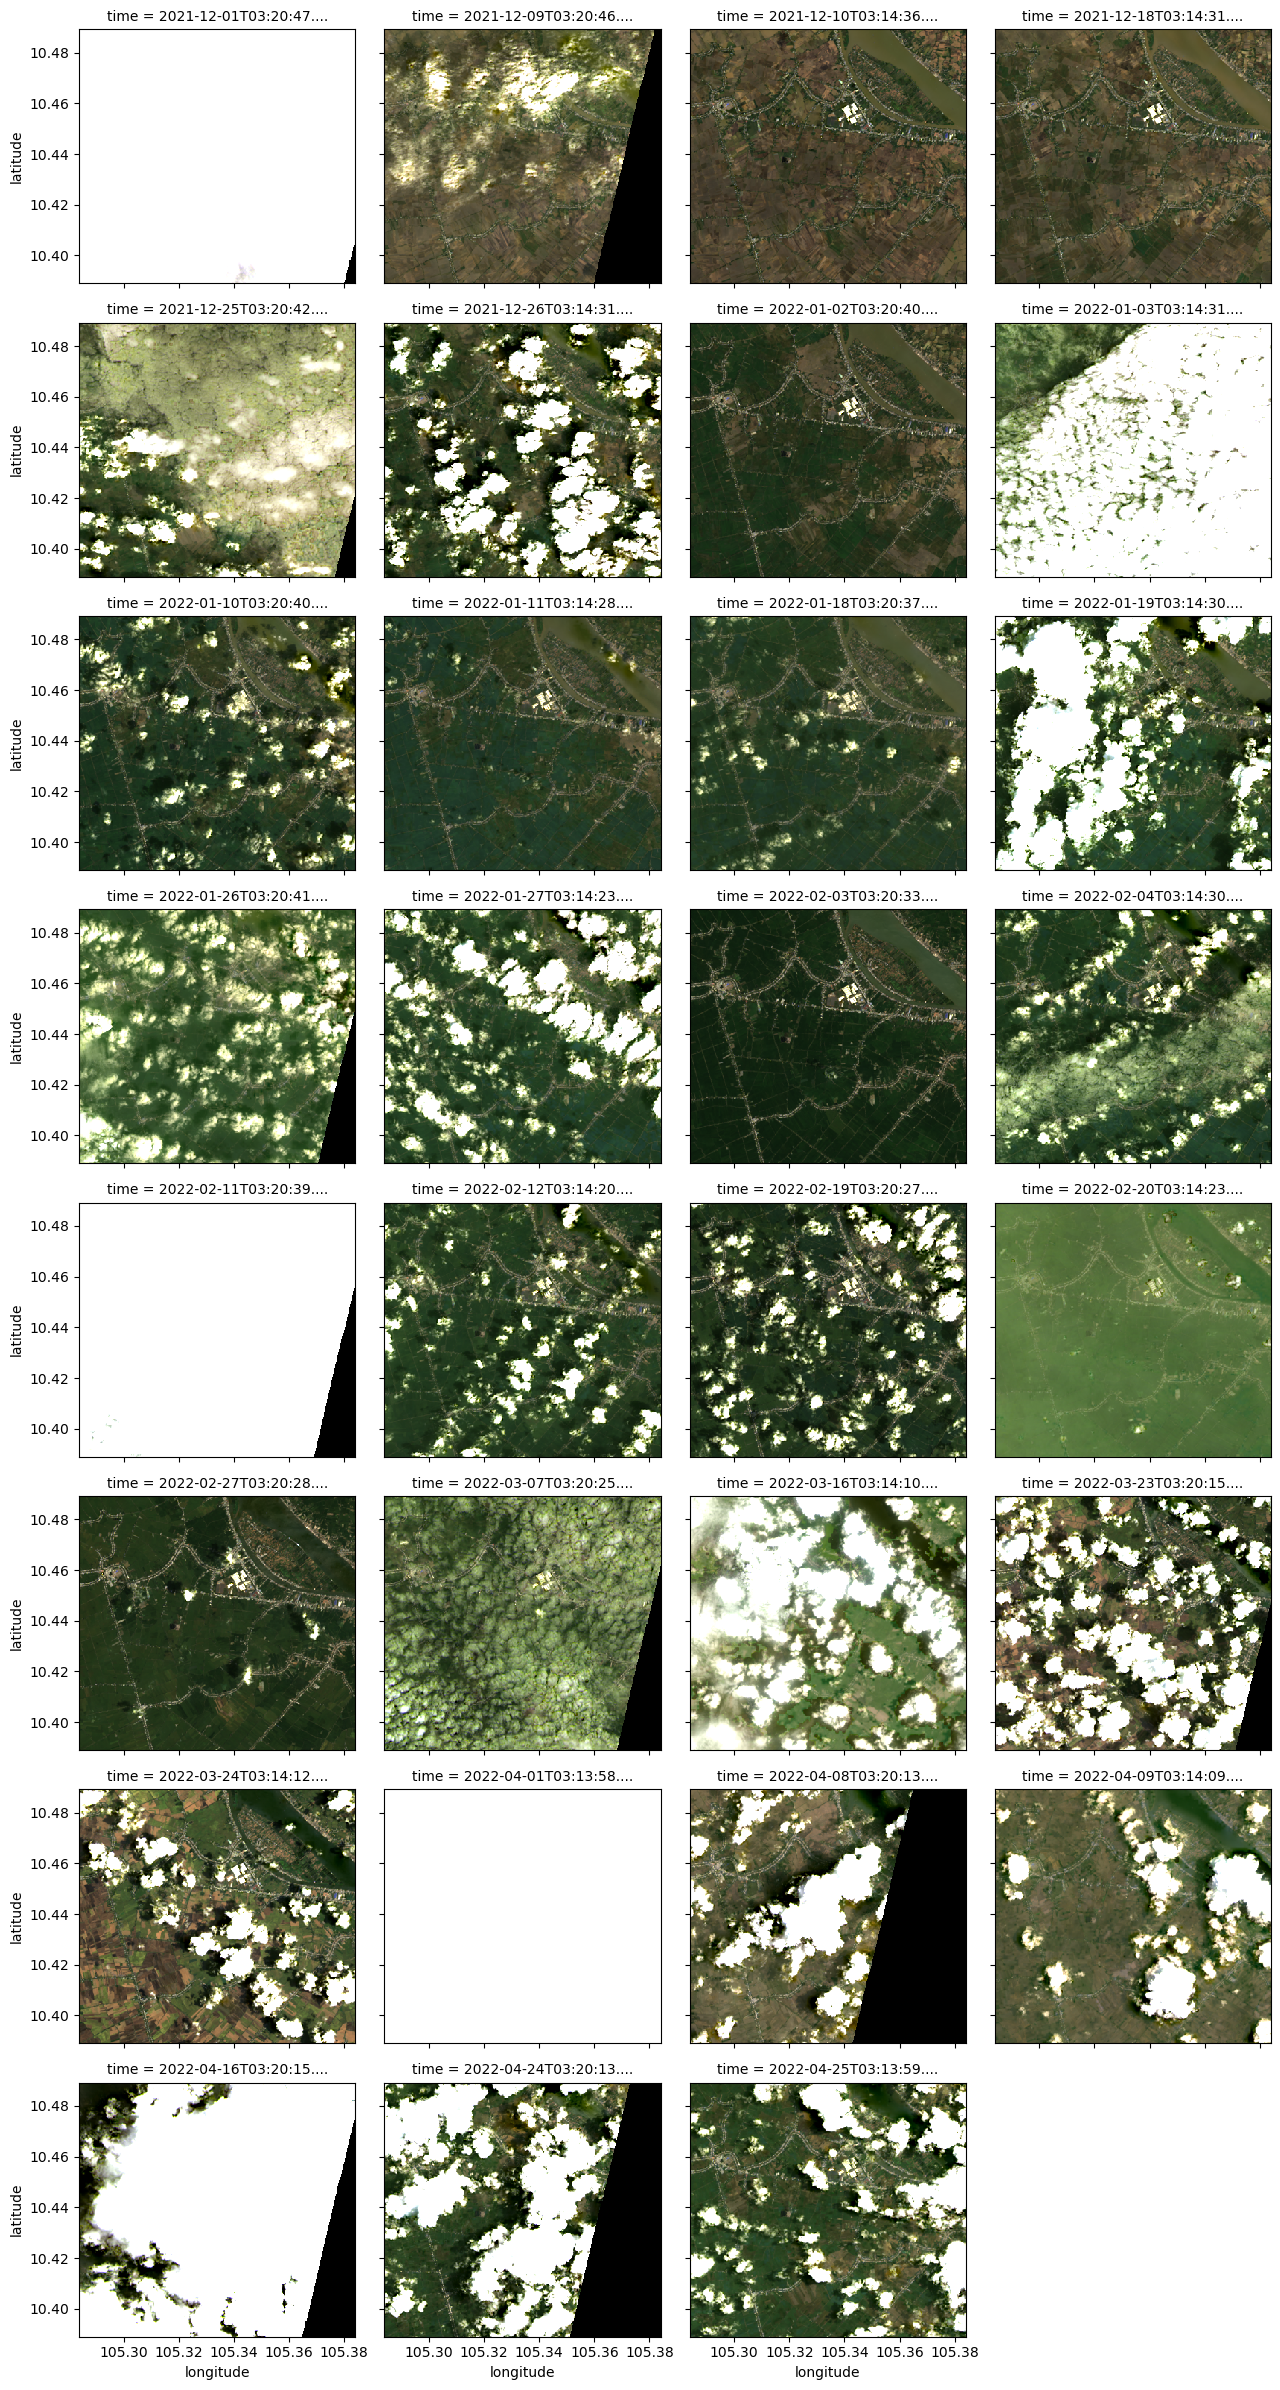

In [8]:
# Plot 31 scenes from the region
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.3)
plt.show()

In [9]:
# Select a time slice to view a simple RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices (starts at 0)

# Slice #6 - Mostly Clear
# Slice #24 - Scattered Clouds
# Slice #7 - Very Cloudy

time_slice = 5

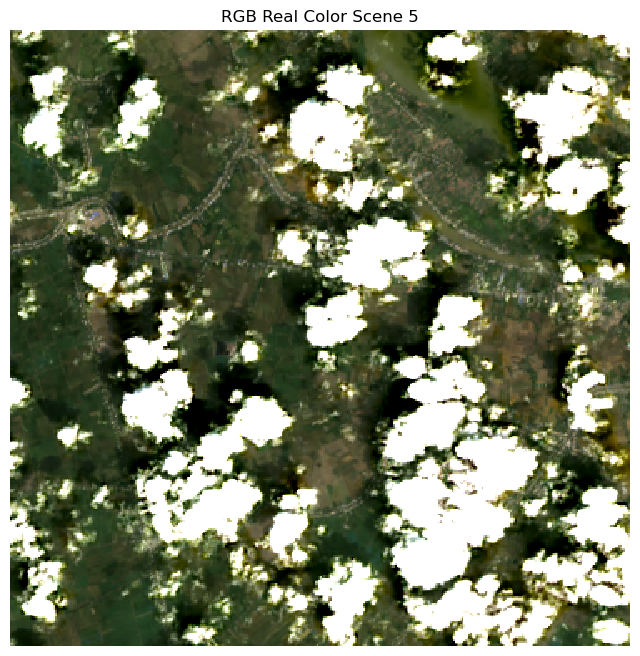

In [10]:
# Plot a RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=0.3)
ax.set_title("RGB Real Color Scene 5")
ax.axis('off')
plt.show()

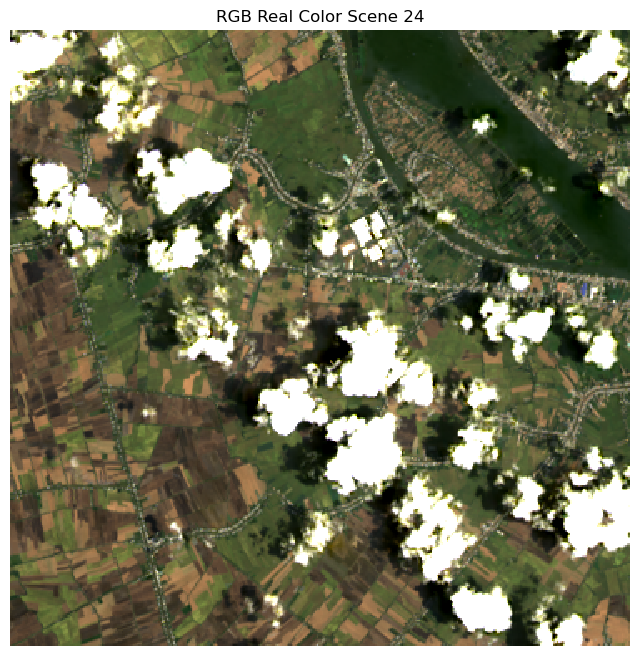

In [11]:
time_slice = 24

# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=0.3)
ax.set_title("RGB Real Color Scene 24")
ax.axis('off')
plt.show()

There are clouds over some of the scenes. So, we need to apply cloud filtering to get more accurate images for rice crop detection

### Accessing the Sentinel-1 data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. 

In [12]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    box_size_deg1 = 0.0004 # Surrounding box in degrees, yields approximately 5x5 pixel region
    resolution2 = 10  # meters per pixel 
    scale2 = resolution2 / 111320.0 # degrees per pixel for crs=4326 

    #latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    #bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    
    
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')

      # Calculate the Lat-Lon bounding box region
    min_lon = float(latlong[1])-box_size_deg1/2
    min_lat = float(latlong[0])-box_size_deg1/2
    max_lon = float(latlong[1])+box_size_deg1/2
    max_lat = float(latlong[0])+box_size_deg1/2
    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = time_slice
    

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest, 
    )
    items = list(search.get_all_items())
    bands_of_interest = assets
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale2).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    return vh,vv

In [13]:
bit_flags = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2, 
            'cloud': 1<<3,
            'shadow': 1<<4, 
            'snow': 1<<5, 
            'clear': 1<<6,
            'water': 1<<7
}

# Create a function that will mask pixels with a given type

def get_mask(mask, flags_list):
    
    # Create the result mask filled with zeros and the same shape as the mask
    final_mask = np.zeros_like(mask)
    
    # Loop through the flags  
    for flag in flags_list:
        
        # get the mask for each flag
        flag_mask = np.bitwise_and(mask, bit_flags[flag])
        
        # add it to the final flag
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

### Accessing the Landsat 8-9 data

<p align = "Justify">To get the Landsat 8-9 data, we write a function called <i><b>get_landsat_data.</b></i> This function will fetch red, green, blue, nir08 and swir16 band values for a particular location over the specified time window. 

Created a cloud mask over the optical satellite images (landsat 8-9) to remove clouds and cloud shadows that obscure land surface features and changes the reflectance of ground objects.

In [14]:
def get_landsat_data(latlong, time_slice, assets):
    box_size_deg2 = 0.10 
    resolution1 = 30  # meters per pixel 
    scale1 = resolution1 / 111320.0 # degrees per pixel for CRS:4326 
    
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')

      # Calculate the Lat-Lon bounding box region
    min_lon = float(latlong[1])-box_size_deg2/2
    min_lat = float(latlong[0])-box_size_deg2/2
    max_lon = float(latlong[1])+box_size_deg2/2
    max_lat = float(latlong[0])+box_size_deg2/2
    bbox_of_interest2 = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["landsat-c2-l2"], bbox=bbox_of_interest2, datetime=time_slice, 
        query={"platform": {"in": ["landsat-8", "landsat-9"]}, "eo:cloud_cover": {"lt": 15}}
    )
    # search = catalog.search(
    #     collections=["landsat-c2-l2"], bbox=bbox_of_interest2, datetime=time_slice, 
    #     query={ "eo:cloud_cover": {"lt": 10}}
    # )
    items = list(search.get_all_items())
    bands_of_interest = assets
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest2, crs="EPSG:4326", resolution=scale1).isel(time=0)

    data['red'] = (data['red']*0.0000275)-0.2
    data['green'] = (data['green']*0.0000275)-0.2
    data['blue'] = (data['blue']*0.0000275)-0.2
    data['nir08'] = (data['nir08']*0.0000275)-0.2
    data['swir16'] = (data['swir16']*0.0000275)-0.2 

    # Create a "clean" dataset with the mask applied 
    # Calculate the mask for the entire xarray (all time slices)
    full_mask = get_mask(data['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'shadow', 'water'])
    cleaned_data = data.where(~full_mask)
    
    band_values = {}
    for band in bands_of_interest:
        band_values[band] = data[band].astype("float").values.tolist()[0][0]
    return band_values

In [15]:
def calculate_lai(red, nir, qa_pixel):
    """
    Calculate Leaf Area Index (LAI) from Landsat red, NIR, and QA bands.

    Args:
        red (numpy.ndarray): Red band values.
        nir (numpy.ndarray): Near-Infrared band values.
        qa_pixel (numpy.ndarray): Quality Assessment band values.

    Returns:
        numpy.ndarray: LAI values.
    """
    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)

    # Convert QA band to integer data type
    qa_pixel = qa_pixel.astype(np.uint16)

    # Apply QA band mask to exclude cloud, cloud shadow, cirrus, and other unwanted pixels
    valid_mask = (qa_pixel & 0b11111111111111110000000000000000) == 0
    ndvi = np.where(valid_mask, ndvi, np.nan)

    # Calculate LAI from NDVI using an empirical model
    # Example model: LAI = -0.623 + 3.618 * NDVI (Clevers, 1988)
    lai = -0.623 + 3.618 * ndvi

    return lai

In [16]:
## Function call to extract VV,VH Values
time_slice = "2021-11-01/2022-03-30"
assets = ['vh', 'vv']
vh_vv = []

# Calculate the mean VV and VH values outside the loop
mean_vh = np.zeros(len(crop_presence_data))
mean_vv = np.zeros(len(crop_presence_data))

for i, coordinates in tqdm(enumerate(crop_presence_data['Latitude and Longitude'])):
    vh, vv = get_sentinel_data(coordinates, time_slice, assets)
    mean_vh[i] = np.mean(vh)
    mean_vv[i] = np.mean(vv)

# Compute Doppler overage
dop = mean_vv / (mean_vv + mean_vh)

# Calculate Soil Moisture
A = 0.71
B = 1.40
soil_moisture = 1 - ((10 ** (0.1 * dop)) / A) ** B

vh_vv_data = pd.DataFrame({'vh': mean_vh, 'vv': mean_vv, 'sm': soil_moisture})

#2022-02-01/2022-03-30 - ALMOST PEAK
#2021-11-01/2022-03-30 - first cycle

#2022-01-01/2022-03-30 - jan-mar (vv, vh)
#2022-03-7/2022-05-15 - mar - may (nvdi)

#(Below mentioned are test/train correlation matrix outputs)
#2021-11-01/2022-04-30 - 0.2/0.6 corr
#2021-11-01/2022-03-30 - 0.4/0.4 corr
#2021-11-01/2022-08-30 - 0.55/0.55 corr
#2021-09-01/2022-03-30 - 0.45/0.45 corr + 59%
#2021-08-01/2022-03-31 - as per doc

600it [02:29,  4.02it/s]


In [17]:
## Function call to extract band values
time_slice = "2021-11-01/2022-03-30"
assets1 = ["red", "green", "blue", "nir08", "swir16", "qa_pixel"]
band_data = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    band_data.append(get_landsat_data(coordinates, time_slice, assets1))
band_df = pd.DataFrame(band_data, columns=assets1)

100%|██████████| 600/600 [10:48<00:00,  1.08s/it]


In [18]:
# Extract the band values as NumPy arrays
red = band_df['red'].values
nir = band_df['nir08'].values
qa_pixel = band_df['qa_pixel'].values

# Calculate LAI using the function from earlier
lai_values = calculate_lai(red, nir, qa_pixel)

In [19]:
# Constants for EVI calculation
G = 2.5
C1 = 6
C2 = 7.5
L = 1

# Extract the band values as NumPy arrays
red = band_df['red'].values
nir = band_df['nir08'].values
blue = band_df['blue'].values
green = band_df['green'].values
swir16 = band_df['swir16'].values
qa_pixel = band_df['qa_pixel'].values

# Convert QA band to integer data type
qa_pixel = qa_pixel.astype(np.uint16)

# Apply QA band mask to exclude cloud, cloud shadow, cirrus, and other unwanted pixels
valid_mask = (qa_pixel & 0b11111111111111110000000000000000) == 0

# Calculate NDVI
ndvi = np.where(valid_mask, (nir - red) / (nir + red), np.nan)

# Calculate EVI
evi = np.where(valid_mask, G * ((nir - red) / (nir + C1 * red - C2 * blue + L)), np.nan)

# Calculate SAVI
savi = np.where(valid_mask, ((nir - red) / (nir + red + 0.5)) * 1.5, np.nan)

# Calculate Albedo
albedo = np.where(valid_mask, 0.356 * blue + 0.130 * green + 0.373 * red + 0.085 * nir + 0.072 * swir16 + 0.0018, np.nan)

In [20]:
vh_vv_data['ndvi'] = ndvi
vh_vv_data['albedo'] = albedo
vh_vv_data['Class of Land'] = crop_presence_data['Class of Land']

In [21]:
vh_vv_data

vh        vv        sm      ndvi    albedo Class of Land
0    0.037220  0.044072 -0.923706  0.842562  0.075631          Rice
1    0.040474  0.207924 -1.115567  0.858809  0.064393          Rice
2    0.051322  0.125724 -1.030744  0.777127  0.074049          Rice
3    0.027067  0.030455 -0.915853  0.786230  0.071576          Rice
4    0.103143  0.593373 -1.125722  0.699381  0.097277          Rice
..        ...       ...       ...       ...       ...           ...
595  0.032364  0.288535 -1.158334  0.806685  0.095736      Non Rice
596  0.051440  0.318289 -1.131868  0.791275  0.091704      Non Rice
597  0.069973  0.067018 -0.891159  0.793396  0.093642      Non Rice
598  0.034858  0.346996 -1.165002  0.732929  0.081908      Non Rice
599  0.025329  0.278942 -1.170620  0.717369  0.081242      Non Rice

[600 rows x 6 columns]

In [22]:
band_df

red     green      blue     nir08    swir16  qa_pixel
0    0.035235  0.058582  0.024730  0.412370  0.128020   21824.0
1    0.027755  0.046648  0.019753  0.365400  0.112290   21824.0
2    0.041752  0.059298  0.027727  0.332922  0.149965   21824.0
3    0.040735  0.059737  0.026847  0.340375  0.115645   21824.0
4    0.064605  0.082315  0.050553  0.365207  0.161652   21824.0
..        ...       ...       ...       ...       ...       ...
595  0.050085  0.077090  0.037380  0.468085  0.168583   21824.0
596  0.050470  0.075852  0.036032  0.433132  0.160745   21824.0
597  0.051460  0.077530  0.035785  0.446690  0.164733   21824.0
598  0.050800  0.069445  0.035675  0.329622  0.158517   21824.0
599  0.052450  0.069665  0.036692  0.318705  0.148178   21824.0

[600 rows x 6 columns]

## Clustering

In [23]:
# Manually processing the 'Latitude and Longitude' string to split into 'latitude' and 'longitude' columns
def process_latlong(latlong_str):
    lat, lon = latlong_str.replace('(', '').replace(')', '').replace(' ', '').split(',')
    return float(lat), float(lon)

# Applying the conversion function to the 'Latitude and Longitude' column
crop_presence_data[['latitude', 'longitude']] = crop_presence_data['Latitude and Longitude'].apply(
    lambda x: pd.Series(process_latlong(x))
)

In [24]:
from sklearn.preprocessing import StandardScaler

features = vh_vv_data[['vh', 'vv', 'sm', 'ndvi', 'albedo']]
#features = crop_data[['vh', 'vv']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Optionally, add scaled features back to crop_data if you plan to use them for clustering
vh_vv_data[['vh_scaled', 'vv_scaled', 'sm_scaled', 'ndvi_scaled', 'albedo_sclaed']] = features_scaled
#crop_data[['vh_scaled', 'vv_scaled']] = features_scaled

In [25]:
from sklearn.cluster import KMeans

# Perform KMeans clustering on the scaled features for the entire dataset
features_scaled = vh_vv_data[['vh_scaled', 'vv_scaled', 'sm_scaled', 'ndvi_scaled', 'albedo_sclaed']]
#features_scaled = crop_data[['vh_scaled', 'vv_scaled']]
kmeans = KMeans(n_clusters=10, random_state=42)  # Use an extra cluster than originally planned
vh_vv_data['cluster_label'] = kmeans.fit_predict(features_scaled)

# Analyze clusters to see if any corresponds predominantly to "Rice"
# This is a post-analysis step to understand the composition of clusters
for i in range(10):  # Assuming 5 clusters
    cluster_members = vh_vv_data[vh_vv_data['cluster_label'] == i]
    rice_count = cluster_members[cluster_members['Class of Land'] == 'Rice'].shape[0]
    non_rice_count = cluster_members[cluster_members['Class of Land'] == 'Non Rice'].shape[0]
    print(f"Cluster {i}: Rice={rice_count}, Non Rice={non_rice_count}")


Cluster 0: Rice=35, Non Rice=18
Cluster 1: Rice=4, Non Rice=49
Cluster 2: Rice=38, Non Rice=62
Cluster 3: Rice=78, Non Rice=10
Cluster 4: Rice=128, Non Rice=15
Cluster 5: Rice=1, Non Rice=10
Cluster 6: Rice=9, Non Rice=16
Cluster 7: Rice=5, Non Rice=53
Cluster 8: Rice=0, Non Rice=39
Cluster 9: Rice=2, Non Rice=28


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.

In [26]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [27]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_data)
crop_data.head()

Latitude and Longitude Class of Land   latitude  \
0   (10.323727047081501, 105.2516346045924)          Rice  10.323727   
1  (10.322364360592521, 105.27843410554115)          Rice  10.322364   
2  (10.321455902933202, 105.25254306225168)          Rice  10.321456   
3  (10.324181275911162, 105.25118037576274)          Rice  10.324181   
4  (10.324635504740822, 105.27389181724476)          Rice  10.324636   

    longitude        vh        vv        sm      ndvi    albedo Class of Land  \
0  105.251635  0.037220  0.044072 -0.923706  0.842562  0.075631          Rice   
1  105.278434  0.040474  0.207924 -1.115567  0.858809  0.064393          Rice   
2  105.252543  0.051322  0.125724 -1.030744  0.777127  0.074049          Rice   
3  105.251180  0.027067  0.030455 -0.915853  0.786230  0.071576          Rice   
4  105.273892  0.103143  0.593373 -1.125722  0.699381  0.097277          Rice   

   vh_scaled  vv_scaled  sm_scaled  ndvi_scaled  albedo_sclaed  cluster_label  
0  -0.021340  -0.893256   1.928150     1.044436      -0.603441              3  
1   0.070646   0.303436  -0.297522     1.116599      -0.826313              2  
2   0.377364  -0.296912   0.686466     0.753792      -0.634812              3  
3  -0.308413  -0.992709   2.019247     0.794224      -0.683857              3  
4   1.842509   3.118574  -0.415324     0.408465      -0.174184              9

## Model building


<p align="justify"> Now let us select the columns required for our model building. We will consider only VV and VH for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

In [28]:
crop_data = crop_data[['vh','vv','Class of Land']]
crop_data = crop_data.drop(columns=crop_data.columns[2])

In [29]:
crop_data

vh        vv
0    0.037220  0.044072
1    0.040474  0.207924
2    0.051322  0.125724
3    0.027067  0.030455
4    0.103143  0.593373
..        ...       ...
595  0.032364  0.288535
596  0.051440  0.318289
597  0.069973  0.067018
598  0.034858  0.346996
599  0.025329  0.278942

[600 rows x 2 columns]

In [30]:
#crop_data['nvdi'] = ndvi
#crop_data['evi'] = evi
#crop_data['savi'] = savi
#crop_data['albedo'] = albedo
#crop_data['lai'] = lai_values
# Assuming 'column_to_drop' is the name of the column you want to drop



crop_data.head()

vh        vv
0  0.037220  0.044072
1  0.040474  0.207924
2  0.051322  0.125724
3  0.027067  0.030455
4  0.103143  0.593373

In [31]:
# # Drop the column you want to remove
# column_to_drop = 'Class of Land'
# crop_data_corr = crop_data.drop(columns=[column_to_drop])

# # Check the correlation between the remaining variables
# correlation_matrix = crop_data_corr.corr()

# # Print the correlation matrix
# print("Correlation Matrix:")
# print(correlation_matrix)

### Train and test split 

<p align="justify">We will now split the data into 70% training data and 30% test data. 

In [32]:
crop_presence_data['Class of Land']

0          Rice
1          Rice
2          Rice
3          Rice
4          Rice
         ...   
595    Non Rice
596    Non Rice
597    Non Rice
598    Non Rice
599    Non Rice
Name: Class of Land, Length: 600, dtype: object

In [33]:
X = crop_data.values
y = crop_presence_data['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

In [34]:
X_test

array([[0.05409292, 0.14880009],
       [0.00274576, 0.01695384],
       [0.06116362, 0.13542283],
       [0.08721568, 0.09335751],
       [0.05132211, 0.12572393],
       [0.00703511, 0.04154238],
       [0.01073804, 0.05289875],
       [0.03330064, 0.26286164],
       [0.0099071 , 0.04985336],
       [0.05128333, 0.05723654],
       [0.00419288, 0.13064618],
       [0.00759832, 0.01466743],
       [0.01408864, 0.08378205],
       [0.00772699, 0.04395105],
       [0.07871124, 0.14862983],
       [0.0887287 , 0.15479296],
       [0.04929141, 0.15431474],
       [0.00655724, 0.0477964 ],
       [0.00524319, 0.01298888],
       [0.00382192, 0.03176948],
       [0.07257885, 0.66786981],
       [0.04736486, 0.13522699],
       [0.01262364, 0.28272828],
       [0.09070827, 0.48756683],
       [0.03622805, 0.20671222],
       [0.01643604, 0.05824989],
       [0.06123102, 0.18345821],
       [0.00407818, 0.02258432],
       [0.09300023, 0.49990806],
       [0.0040447 , 0.13990304],
       [0.

### Feature scaling 

In [35]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. We will use logistic as the base model.</p>

### Logistic regression

In [36]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)

LogisticRegression()

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

In [38]:
# Logistic regression predictions
y_pred_lg = model.predict(X_test)
y_pred_proba_lg = model.predict_proba(X_test)[:, 1]

In [39]:
# Evaluate the model
accuracy_lg = accuracy_score(y_test, y_pred_lg)
precision_lg = precision_score(y_test, y_pred_lg, pos_label='Rice')
recall_lg = recall_score(y_test, y_pred_lg, pos_label='Rice')
f1_lg = f1_score(y_test, y_pred_lg, pos_label='Rice')
roc_auc_lg = roc_auc_score(y_test, y_pred_proba_lg)

# Print evaluation metrics
print("Accuracy: {:.2f}".format(accuracy_lg))
print("Precision: {:.2f}".format(precision_lg))
print("Recall: {:.2f}".format(recall_lg))
print("F1 Score: {:.2f}".format(f1_lg))
print("ROC AUC Score: {:.2f}".format(roc_auc_lg))

Accuracy: 0.63
Precision: 0.62
Recall: 0.71
F1 Score: 0.66
ROC AUC Score: 0.58


In [40]:
# Print confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lg))
print("Classification Report:\n", classification_report(y_test, y_pred_lg, target_names=['Non Rice', 'Rice']))

Confusion Matrix:
 [[50 40]
 [26 64]]
Classification Report:
               precision    recall  f1-score   support

    Non Rice       0.66      0.56      0.60        90
        Rice       0.62      0.71      0.66        90

    accuracy                           0.63       180
   macro avg       0.64      0.63      0.63       180
weighted avg       0.64      0.63      0.63       180



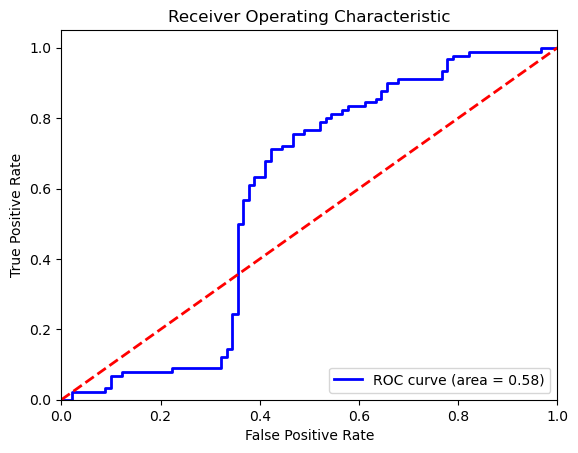

In [41]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lg, pos_label='Rice')
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lg)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### XGBoost

In [42]:
from sklearn.preprocessing import LabelEncoder

In [43]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [44]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Defining the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic'  
)

# Defining the hyperparameters grid for tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10]
}

# Performing grid search cross-validation
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, n_iter=500, cv=3, scoring='accuracy')
random_result_xgb = random_search_xgb.fit(X_train, y_train_encoded)

# Getting the best parameters
best_params_xgb = random_result_xgb.best_params_
print("Best Parameters XGB:", best_params_xgb)

# Training the model with the best parameters
best_model_xgb = xgb.XGBClassifier(**best_params_xgb)
best_model_xgb.fit(X_train, y_train_encoded)

# Making predictions on the test set
y_pred_xgb = best_model_xgb.predict(X_test)

# Evaluating the model
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print("Accuracy XGB:", accuracy_xgb)

Best Parameters XGB: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.001, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Accuracy XGB: 0.7333333333333333


### K-nearest neighbors (KNN)

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

# Define the KNN classifier
knn = KNeighborsClassifier()

# Define the grid of hyperparameters to search
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric to use
}

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')

# Perform hyperparameter tuning on the training set
grid_search_knn.fit(X_train_imputed, y_train)

# Get the best hyperparameters
best_params_knn = grid_search_knn.best_params_
print("Best KNN Hyperparameters:", best_params_knn)

# Use the best model to make predictions on the test set
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_imputed)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy_knn)

Best KNN Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy: 0.7722222222222223


### Random forest

In [46]:
#Random Forest with grid search and nested cv

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import numpy as np

# Outer CV loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store scores of each fold
outer_scores = []

for training_samples, validation_samples in outer_cv.split(X, y):
    # Split the data into training and validation sets
    X_train, X_valid = X[training_samples], X[validation_samples]
    y_train, y_valid = y[training_samples], y[validation_samples]
    
    # GridSearchCV acts as the inner loop for hyperparameter tuning
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model from grid search
    best_model = grid_search.best_estimator_
    
    # Evaluate on the validation set
    score = best_model.score(X_valid, y_valid)
    outer_scores.append(score)

# Display the results of the nested cross-validation
print("Nested CV score (ROC AUC): Mean = {:.3f}, Std = {:.3f}".format(np.mean(outer_scores), np.std(outer_scores)))

Nested CV score (ROC AUC): Mean = 0.785, Std = 0.027


In [67]:
train_rf = best_model.predict(X_train)

print("Train  set accuracy {0:.2f}%".format(100*accuracy_score(train_rf,y_train)))
print(classification_report(train_rf,y_train))

Train  set accuracy 94.58%
              precision    recall  f1-score   support

    Non Rice       0.95      0.94      0.95       245
        Rice       0.94      0.95      0.95       235

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480



In [58]:
# Evaluate on test set
y_pred_rf = best_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

Accuracy: 0.5388888888888889


The substantial discrepancy between the training set accuracy (94.58%) and the test set accuracy (53.89%) indicates that the random forest model is significantly overfitting

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report for best model using k-nearest neighbor algorithm and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. </p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [59]:
insample_predictions = best_knn.predict(X_train)

In [60]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 60.62%
              precision    recall  f1-score   support

    Non Rice       0.78      0.58      0.67       326
        Rice       0.43      0.66      0.52       154

    accuracy                           0.61       480
   macro avg       0.61      0.62      0.59       480
weighted avg       0.67      0.61      0.62       480



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [61]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

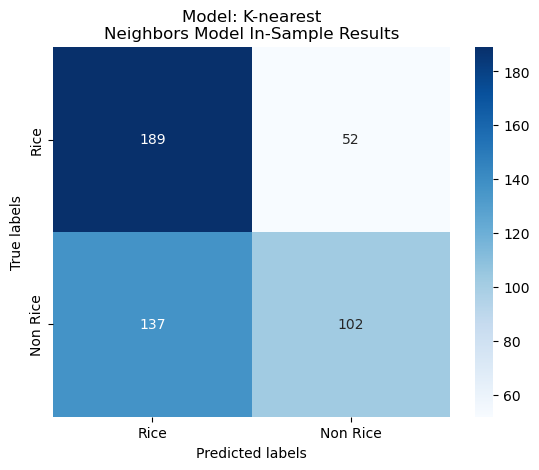

In [62]:
plot_confusion_matrix(y_train,insample_predictions,"Model: K-nearest\nNeighbors Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [63]:
outsample_predictions = best_knn.predict(X_test)

In [64]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 77.22%
              precision    recall  f1-score   support

    Non Rice       0.74      0.84      0.79        90
        Rice       0.82      0.70      0.75        90

    accuracy                           0.77       180
   macro avg       0.78      0.77      0.77       180
weighted avg       0.78      0.77      0.77       180



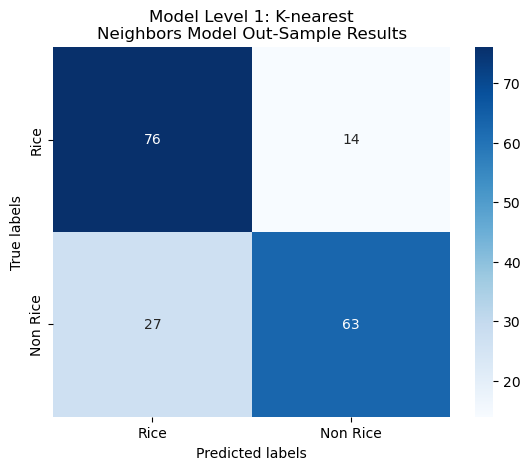

In [65]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: K-nearest\nNeighbors Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.77</b>. 